In [2]:
import librosa
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scripts import setup
from scripts.extract_audio_features import extract_zcr, extract_loudness, extract_rhythm, create_target_variable, pad_audio

In [3]:
gt_211 =  pd.read_csv("../ground_truth_data/GroundTruth_Muppets-02-01-01.csv", sep=";")
gt_244 =  pd.read_csv("../ground_truth_data/GroundTruth_Muppets-02-04-04.csv", sep=";")
gt_343 =  pd.read_csv("../ground_truth_data/GroundTruth_Muppets-03-04-03.csv", sep=";")

In [4]:
video_path = "../ground_truth_data/Muppets-02-01-01.avi"

In [5]:
pig_annotations = gt_211.loc[gt_211["Pigs"] == 1]

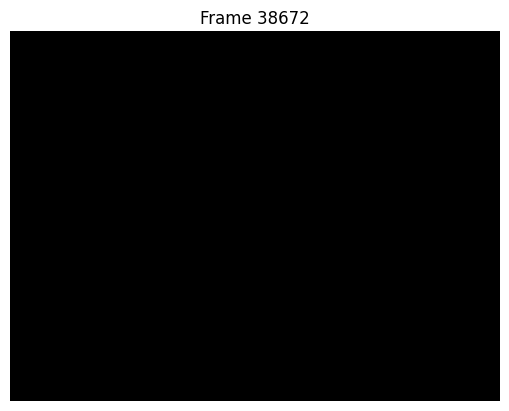

In [16]:
video_path = "../ground_truth_data/Muppets-02-01-01.avi"

frame_number = 38672

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

if ret:
    # convert the frame from BGR (OpenCV format) to RGB for matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # display the frame using matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off') 
    plt.title(f"Frame {frame_number}")
    plt.show()
else:
    print(f"Frame {frame_number} could not be found.")

cap.release()

# Pigs

## SIFT

In [5]:
cap = cv2.VideoCapture(video_path)

frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray_frame) 
cap.release()

In [6]:
# extract frames where pigs are annotated
pig_frames = [frames[idx] for idx in pig_annotations['Frame_number']]

sift = cv2.SIFT_create()

pig_keypoints_list = []
pig_descriptors_list = []

for frame in pig_frames:
    keypoints, descriptors = sift.detectAndCompute(frame, None)
    pig_keypoints_list.append(keypoints)
    pig_descriptors_list.append(descriptors)

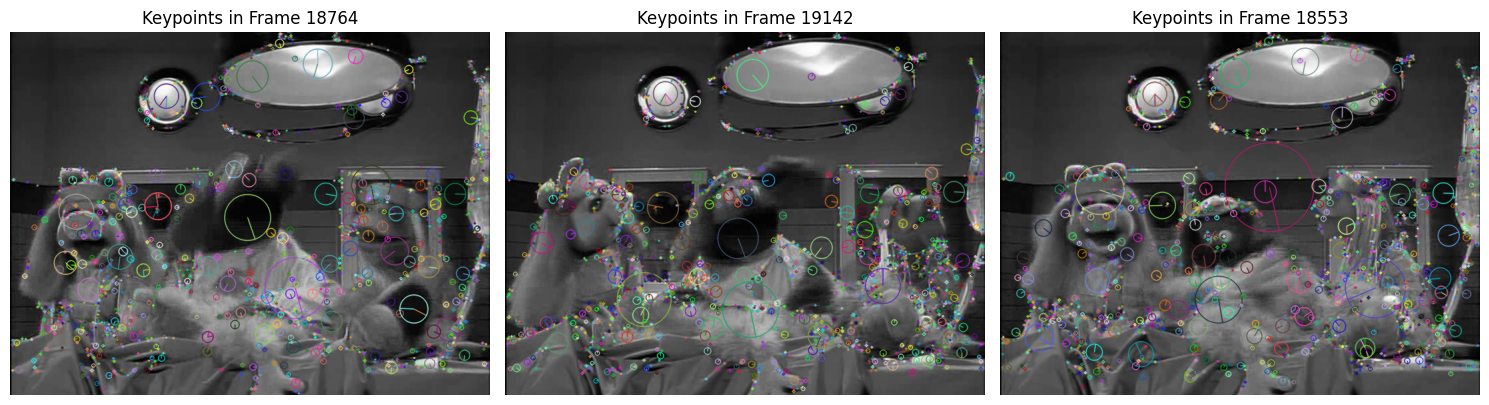

In [ ]:
random_indices = random.sample(range(len(pig_frames)), 3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, rand_idx in enumerate(random_indices):
    frame = pig_frames[rand_idx]
    keypoints = pig_keypoints_list[rand_idx]
    
    frame_with_keypoints = cv2.drawKeypoints(frame, keypoints, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    frame_with_keypoints_rgb = cv2.cvtColor(frame_with_keypoints, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(frame_with_keypoints_rgb)
    axes[idx].set_title(f"Keypoints in Frame {pig_annotations.iloc[rand_idx]['Frame_number']}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


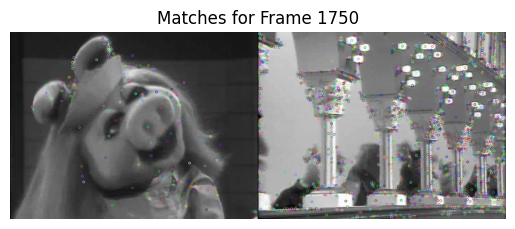

In [14]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

template = cv2.cvtColor(cv2.imread('../ground_truth_data/frames/Muppets-02-01-01_frame19509.png'), cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
keypoints_template, descriptors_template = sift.detectAndCompute(template, None)

frame = pig_frames[0]  
descriptors = pig_descriptors_list[0] 

if descriptors is not None:
    matches = bf.match(descriptors_template, descriptors)
    matches = sorted(matches, key=lambda x: x.distance)  

    good_matches = [match for match in matches if match.distance < 50]

    frame_with_matches = cv2.drawMatches(template, keypoints_template, frame, pig_keypoints_list[0], good_matches, None)

    frame_with_matches_rgb = cv2.cvtColor(frame_with_matches, cv2.COLOR_BGR2RGB)

    plt.imshow(frame_with_matches_rgb)
    plt.axis('off')
    plt.title(f"Matches for Frame {pig_annotations.iloc[0]['Frame_number']}")
    plt.show()
else:
    print(f"No descriptors found for the selected frame.")
